<a href="https://colab.research.google.com/github/benon33/w207-final/blob/main/Final%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Executive Summary 
##### **Context**: As smartphones have become more accessible across the world, social media outlets, such as Twitter, have become important means of communicating during times of an emergency. As a result, more organizations are interested in tracking conversations in this space to respond more quickly.

**Problem**: However, a user's intent in a tweet isn't always clear. Words, such as "ablaze", can be used in multiple contexts. It can be descriptive of a sunset or it could be indicative of something more serious, like a forest fire. 

##### **Approach**: For this project, we will use a data set of twitter posts, found on [Kaggle](https://www.kaggle.com/c/nlp-getting-started). The goal is to identify an algorithm that most accuractely classifies a tweet as indicative of a real disaster or not a real disaster. 

**Summary**:



In [40]:
%matplotlib inline

!pip install geonamescache
!pip install nltk
!pip install wordcloud

# General libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# SK-learn decomp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# SK-learn libraries for feature extraction from text
from sklearn.feature_extraction.text import *

# NLP processors
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, FreqDist
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from numpy import mean
from numpy import std

# WordCloud
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
# TODO: this package nltk.download(wordnet) is for lemmatize to work
# The download did not work so we have to use the below code.. lol
# Commented this out because it wasn't working for me on my GCP instance - maybe we can run it if an environment variable is set?
# The download worked for me

# Please run this code and SSL will pop up a window for you to choose a
# Module to download, click 'all packages' and scroll down
# and select 'wordnet'. You only need to download it once. 
# Not tested in Google Colab :3
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# nltk.download()


# Exploratory Data Analysis: 

* Dataset contains 7613 observations (i.e. rows) and 5 features (i.e.columns)
* Dataset contains missing values and spaces, indicated by NaN and %20 values
* There are 61 missing values under the keyword column
* There are 2533 missing values in the location column
* The training set shows an imbalance between classification types (i.e. tweet is/is not about a disaster)

In [42]:
# Reading in the training data from the competition CSV
train_data =  pd.read_csv('data/nlp-getting-started/train.csv')

print("Shape of train data: {} {}\n".format(train_data.shape[0], train_data.shape[1]))
print("Missing data in each column:\n" + str(train_data.isnull().sum()))

Shape of train data: 7613 5

Missing data in each column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


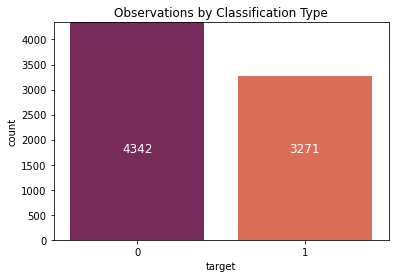

In [43]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart 

# Explore distribution of dataset 
sns.countplot(x = train_data['target'], palette = 'rocket')
ax = plt.gca()
y_max = train_data['target'].value_counts().max() 
ax.set_ylim([0, round(y_max)])
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 1700, '%d' % int(p.get_height()), 
            fontsize=12, color='white', ha='center', va= 'bottom')
plt.title("Observations by Classification Type")
plt.show()

## Understanding Duplicate Data

There are 110 tweets in this dataset. When we explored further, we saw that duplicate tweets were not always classified in the same way. As a result, we decided to drop duplicate tweets from the training set to improve our model accuracy.

In [44]:
duplct_cnt = len(train_data['text'])-len(train_data['text'].drop_duplicates())
train_data['duplicate_tweet'] = np.where(train_data['text'].duplicated(keep=False), 1, 0)
print('The most common duplicate tweets are:')
train_data[train_data.duplicate_tweet == 1].pivot_table(index='text', values='target', aggfunc='count').sort_values(by='target', ascending=False).head(5)

The most common duplicate tweets are:


,target
text,
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives,5


In [45]:
dups = train_data[train_data.duplicate_tweet == 1]
print('Duplicate tweets classification:')
dups[['id', 'text', 'target']].sort_values(by='text', ascending=False).head(5)

Duplicate tweets classification:


,id,text,target
5620,8018,wowo--=== 12000 Nigerian refugees repatriated ...,1
5641,8044,wowo--=== 12000 Nigerian refugees repatriated ...,0
6091,8698,that horrible sinking feeling when youÛªve be...,1
6123,8739,that horrible sinking feeling when youÛªve be...,1
6103,8714,that horrible sinking feeling when youÛªve be...,0


## Location Data Considerations:

Much of the location data is not classified consistently--that is, it contains: 
*   different levels of granularity (countries, states, cities)
*   different versions of the same entity (e.g. United States, USA) 
*   unidentifiable location (e.g. ) 

After attempting to clean the data, we were able to categorize a significant amount of tweets by country, but the vast majority of tweets were unable to be classified correctly. As a result, we determined that it would be best not to include location data in our models.

In [46]:
train_data[['location', 'target']].dropna(subset=['location']).groupby('location').count().sort_values(by='target', ascending=False).head(10)

,target
location,
USA,104
New York,71
United States,50
London,45
Canada,29
Nigeria,28
UK,27
"Los Angeles, CA",26
India,24


In [47]:
#CREDIT TO SOURCES
#https://medium.com/swlh/extracting-location-data-from-twitter-54c837144038
#https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb
#https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
#https://stackoverflow.com/questions/34962104/how-can-i-use-the-apply-function-for-a-single-column

#import libraries 
import geonamescache
from geonamescache.mappers import country

#discuss text_clean function with team -- need it for location EDA 
def text_clean(text):
  #remove line breaks
  text = re.sub(r"\n","",text)

  #convert to lowercase 
  text = text.lower()

  #remove digits and currencies 
  text = re.sub(r"\d+","",text) 
  text = re.sub(r'[\$\d+\d+\$]', "", text)      

  #remove dates 
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
  text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)

  #remove non-ascii
  text = re.sub(r'[^\x00-\x7f]',r' ',text) 

  #remove punctuation
  text = re.sub(r'[^\w\s]','',text) 

  #remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

  #replace extra whitespaces with a single one 
  #text = re.sub(re.sub(' +', ' ', text)
  return text

#break out location identifiers into separate lists
#US-specific identifiers
city_state_mapping =  pd.read_csv('data/EDA-data/city_to_state.csv')
US_map = dict(zip(city_state_mapping.city, city_state_mapping.state))
US_cities = set(city_state_mapping.city)
US_states = set(city_state_mapping.state)

#import mapping function
mapper = country(from_key='iso3', to_key='name')
mapper2 = country(from_key='iso', to_key='name')

#country-specific identifiers 
gc = geonamescache.GeonamesCache()  
country_names = gc.get_countries_by_names()
countries = list(country_names.keys())
countries = [c.lower() for c in countries]
iso3 = [val["iso3"].lower() for key, val in country_names.items() if "iso3" in val]
#iso = [val["iso"].lower() for key, val in country_names.items() if "iso" in val] risks too many incorrect categorizations

#define dataframe; drop null values 
loc_list = train_data[['location', 'target']].dropna(subset=['location'])
loc_list['location'] = loc_list['location'].apply(lambda x: text_clean(x))

#tokenize the location from each user-generated geo-location (word_tokenize) 
loc_list = loc_list.location.apply(nltk.word_tokenize)

#initialize empty list 
country = []

#categorize by country based on list matches
for location in loc_list:
  l = set(location)

  if l.intersection(countries):
    ctry = list(l.intersection(countries))
    country.append(ctry[0])
    continue

  if l.intersection(US_states):
    country.append('united states')
    continue

  if l.intersection(US_cities):
    country.append('united states')
    continue

  if l.intersection(iso3):
    ctry = list(l.intersection(iso3))
    val = mapper(ctry[0].upper())
    country.append(val.lower())
    continue

  # if l.intersection(iso):
  #   ctry = list(l.intersection(iso))
  #   val = mapper2(ctry[0].upper())
  #   country.append(val.lower())
  #   continue

  else:
    country.append('unknown')

ldf = loc_list.to_frame()
ldf['country'] = country
ldf['target'] = train_data['target']

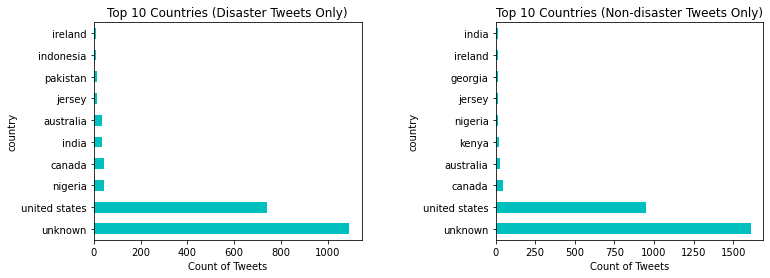

In [48]:
#plot locations by tweet type

disaster_tweets = ldf.loc[ldf['target'] == 1]
dt = disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

non_disaster_tweets = ldf.loc[ldf['target'] == 0]
ndt = non_disaster_tweets[['country', 'location']].groupby('country').count().sort_values(by='location', ascending=False).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=.5)
#fig.suptitle('Tweets by Country')
dt.plot.barh(ax=ax1, color='c', legend=None)
ndt.plot.barh(ax=ax2, color='c', legend=None)

ax1.set_title('Top 10 Countries (Disaster Tweets Only)')
ax2.set_title('Top 10 Countries (Non-disaster Tweets Only)')
ax1.xaxis.set_label_text('Count of Tweets')
ax2.xaxis.set_label_text('Count of Tweets')
plt.show()

## Top Keywords

To better understand the keyword column in our data, we created word clouds that allowed us to understand which keywords were the most found in disaster vs non-disaster tweets.

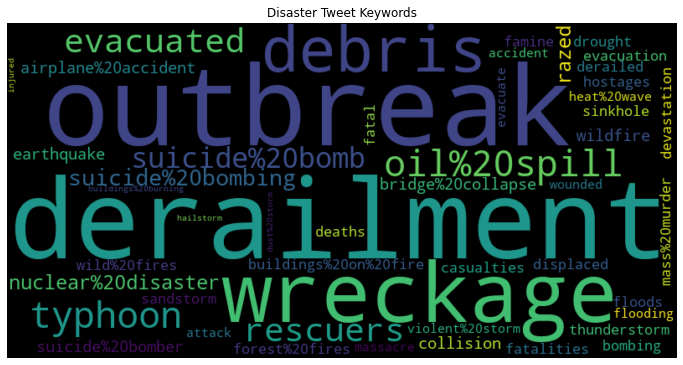

In [49]:
# Code inspired by https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
# Gets us the frequency of words
fdist_0 = FreqDist(train_data[train_data.target == 0 & train_data.keyword.notna()]['keyword'])
fdist_1 = FreqDist(train_data[train_data.target == 1 & train_data.keyword.notna()]['keyword'])

# Generates the WordCloud for disaster tweets
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_1)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Disaster Tweet Keywords")
plt.show()

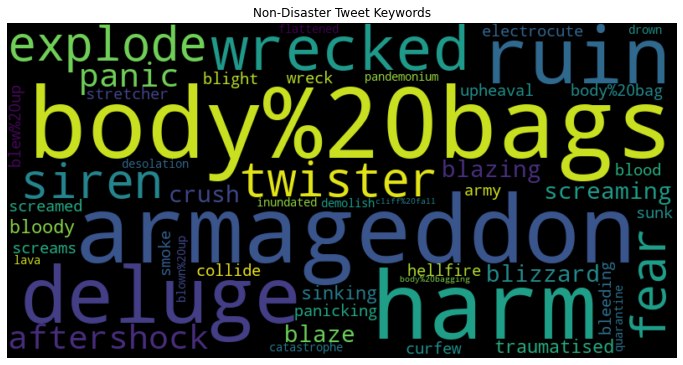

In [50]:
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_0)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Disaster Tweet Keywords")
plt.show()

We can see that there is a lot of conceptual overlap in the keywords in both the disaster and non-disaster tweets. For instance, note how "body bags" is considered a non-disaster tweet keyword, but seems like it should be a disaster keyword. It seems that all of the keywords could be considered as falling under the disaster realm. Additionally, we are not told how these keywords are generated for the Kaggle competition, which makes us not want to trust them for our modeling. Due to all of these factors, are leaning towards dropping them for our analysis.

## Most Popular Bigrams



In [51]:
#CREDIT TO SOURCES: 
#https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python
#https://stackoverflow.com/questions/43473736/most-common-2-grams-using-python

from collections import Counter
from nltk.util import ngrams
from nltk import word_tokenize
# nltk.download('stopwords')

#create dataframe
tweets = train_data[['text', 'target']]

#segment disaster tweets
dt = tweets.loc[tweets['target'] == 1]
dt.columns = ['text', 'target']
dt = dt['text']

#segment non-disaster tweets
ndt = tweets.loc[tweets['target'] == 0]
ndt.columns = ['text', 'target']
ndt = ndt['text']

def count_top_bigrams(tweets):
  #import stop words
  stop_words = set(stopwords.words('english'))

  #clean tweets
  clean_tweets = [word_tokenize(text_clean(tweet)) for tweet in tweets]

  #tokenize tweets and exclude stop words
  token_list = []

  for tweet in clean_tweets:
    tokens = []
    for token in tweet:
      if token not in stop_words:
        tokens.append(token)
    token_list.append(tokens)

  #group tokens as bigrams
  bigram_list = []

  for token in token_list: 
    bigram = list(ngrams(token, 2))
    bigram_list.append(bigram)

  #count bigrams
  cnt = Counter()

  for tweet in bigram_list:
    for bigram in tweet:
      cnt.update(nltk.bigrams(bigram))

  top20 = cnt.most_common(20)
  return top20

#store output as dataframes
db = count_top_bigrams(dt)
disaster_bigrams = pd.DataFrame(db, columns=['bigram', 'count'])

ndb = count_top_bigrams(ndt)
non_disaster_bigrams = pd.DataFrame(ndb, columns=['bigram', 'count'])

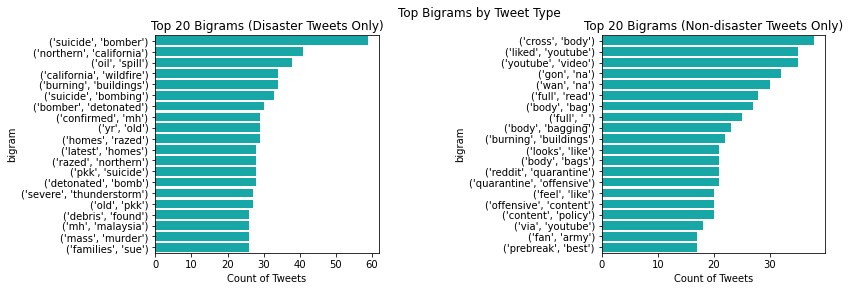

In [52]:
#segment and plot by tweet type

fig, axes = plt.subplots(1, 2, figsize=(12,4))
fig.subplots_adjust(wspace=1)
fig.suptitle('Top Bigrams by Tweet Type')
sns.barplot(x = disaster_bigrams['count'], y = disaster_bigrams['bigram'], color='c', ax = axes[0])
sns.barplot(x = non_disaster_bigrams['count'], y = non_disaster_bigrams['bigram'], color='c', ax=axes[1])

axes[0].set_title('Top 20 Bigrams (Disaster Tweets Only)')
axes[1].set_title('Top 20 Bigrams (Non-disaster Tweets Only)')
axes[0].xaxis.set_label_text('Count of Tweets')
axes[1].xaxis.set_label_text('Count of Tweets')
plt.show()

## Adding Tweet Metadata as Features

During our initial EDA, we noticed that each tweet had 4 pieces of metadata that we thought could be valuable for our models as additional features. These pieces of metadata were:

1. Hashtags
2. Mentions
3. Retweet
4. Links

We decided to create 3 types of features per piece of metadata, with the exception of Retweet as Retweet can only be represented as a binary feature: 

1. A list of the words that comprise the metadata in the tweet, ex. for links, all of the links within a tweet
2. A binary feature for whether a tweet has an instance of the metadata, ex. for links, whether a tweet has at least one link
3. A numeric feature for the number of instances of metadata the tweet has, ex. for links, the number of links in a tweet

We can create these features using the code below.

In [53]:
### First, let's create all of the regexes that we will need
# The hashtag regex captures all word characters that come after a "#" symbol
hashtag_regex = r'#(\w+)'
# The mention regex captures all word characters that come after an "@" symbol
mention_regex = r'@(\w+)'
# In the data, all links are replaced with links that start with "t.co", for example http://t.co/lHYXEOHY6C
# See https://help.twitter.com/en/using-twitter/url-shortener
# The link regex captures all "t.co" links
link_regex = r'(https?:\/\/t.co/\w+)'
# Retweets are indicated by the symbol "rt", because this is a simple string we don't need to use a heavyweight regex
retweet_indicator = "rt"

### Next, let's create feature 1 per relevant piece of metadata, i.e. a list of the words that comprise the metadata in the tweet
def create_regex_finder_lambda(regex):
    return lambda s: re.findall(regex, s)

train_data['hashtags'] = train_data['text'].apply(create_regex_finder_lambda(hashtag_regex))
train_data['mentions'] = train_data['text'].apply(create_regex_finder_lambda(mention_regex))
train_data['links'] = train_data['text'].apply(create_regex_finder_lambda(link_regex))

### Now let's create feature 2, a binary feature for whether a tweet has an instance of the metadata
retweet_indicator_lambda = lambda s: 1 if retweet_indicator in s.lower().split() else 0
generic_indicator_lambda = lambda s: 0 if len(s) == 0 else 1

train_data['is_retweet'] = train_data['text'].apply(retweet_indicator_lambda)
train_data['has_mentions'] = train_data.mentions.apply(generic_indicator_lambda)
train_data['has_hashtags'] = train_data.hashtags.apply(generic_indicator_lambda)
train_data['has_links'] = train_data.links.apply(generic_indicator_lambda)

### Finally, let's create feature 3, a numeric feature for the number of instances of metadata the tweet has
length_lambda = lambda s: len(s)

train_data['mention_count'] = train_data.mentions.apply(length_lambda)
train_data['hashtag_count'] = train_data.hashtags.apply(length_lambda)
train_data['link_count'] = train_data.links.apply(length_lambda)

# Display data
train_data.head(10)

,id,keyword,location,text,target,duplicate_tweet,hashtags,mentions,links,is_retweet,has_mentions,has_hashtags,has_links,mention_count,hashtag_count,link_count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,0,[earthquake],[],[],0,0,1,0,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,0,[],[],[],0,0,0,0,0,0,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,0,[],[],[],0,0,0,0,0,0,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,0,[wildfires],[],[],0,0,1,0,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,0,"[Alaska, wildfires]",[],[],0,0,1,0,0,2,0
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,0,"[RockyFire, CAfire, wildfires]",[],[],0,0,1,0,0,3,0
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,0,"[flood, disaster]",[],[],0,0,1,0,0,2,0
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,0,[],[],[],0,0,0,0,0,0,0
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,0,[],[],[],0,0,0,0,0,0,0
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,0,[],[],[],0,0,0,0,0,0,0


Now that we have these features, we can perform some EDA to better understand the data represented by these features.

In [54]:
# First, let's define all the functions we will need for our calculations
def get_percentage_with_feature(data, feature):
    return (data[feature].sum()/data.shape[0]) * 100

def get_avg_number_of_feature(data, feature):
    return (data[feature].sum()/data.shape[0])

# Now, let's use these functions to analyze our data
print("Percentage of all training tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(train_data, "has_hashtags")))
print("Percentage of all training tweets with mentions: {:.2f}%".format(get_percentage_with_feature(train_data, "has_mentions")))
print("Percentage of all training tweets with links: {:.2f}%".format(get_percentage_with_feature(train_data, "has_links")))
print("Percentage of all training tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(train_data, "is_retweet")))
print("\n")

disaster_train_data = train_data[train_data.target == 1]
nondisaster_train_data = train_data[train_data.target == 0]

print("Percentage of disaster tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_hashtags")))
print("Percentage of non-disaster tweets with hashtags: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_hashtags")))

print("Percentage of disaster tweets with mentions: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_mentions")))
print("Percentage of non-disaster tweets with mentions: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_mentions")))

print("Percentage of disaster tweets with links: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "has_links")))
print("Percentage of non-disaster tweets with links: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "has_links")))

print("Percentage of disaster tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(disaster_train_data, "is_retweet")))
print("Percentage of non-disaster tweets that are retweets: {:.2f}%".format(get_percentage_with_feature(nondisaster_train_data, "is_retweet")))
print("\n")

print("Average number of hashtags for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "hashtag_count")))
print("Average number of hashtags for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "hashtag_count")))

print("Average number of mentions for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "mention_count")))
print("Average number of mentions for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "mention_count")))

print("Average number of links for disaster tweets: {:.2f}".format(get_avg_number_of_feature(disaster_train_data, "link_count")))
print("Average number of links for non-disaster tweets: {:.2f}".format(get_avg_number_of_feature(nondisaster_train_data, "link_count")))
print("\n")

Percentage of all training tweets with hashtags: 22.90%
Percentage of all training tweets with mentions: 26.39%
Percentage of all training tweets with links: 52.15%
Percentage of all training tweets that are retweets: 1.06%


Percentage of disaster tweets with hashtags: 26.23%
Percentage of non-disaster tweets with hashtags: 20.38%
Percentage of disaster tweets with mentions: 20.36%
Percentage of non-disaster tweets with mentions: 30.93%
Percentage of disaster tweets with links: 66.37%
Percentage of non-disaster tweets with links: 41.43%
Percentage of disaster tweets that are retweets: 1.22%
Percentage of non-disaster tweets that are retweets: 0.94%


Average number of hashtags for disaster tweets: 0.50
Average number of hashtags for non-disaster tweets: 0.39
Average number of mentions for disaster tweets: 0.27
Average number of mentions for non-disaster tweets: 0.42
Average number of links for disaster tweets: 0.77
Average number of links for non-disaster tweets: 0.51




From this initial EDA, we can see that there is a difference between disaster tweets and non-disaster tweets in terms of having links, mentions, and hashtags, with a marked difference for links in particular, leading us to believe that these features could provide value for us in modeling.

To complete the EDA on these metadata features, we will also create plots to better understand the distributions of the feature count columns.

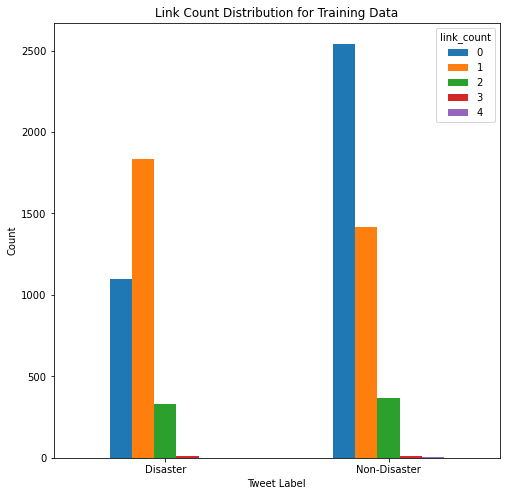

In [55]:
def create_bar_plot(column, title):
    df = train_data.copy(deep=True)
    df['target'].replace({0: "Non-Disaster", 1: "Disaster"}, inplace=True)
    df.pivot_table(index='target', columns=column, aggfunc='size').plot(kind='bar', figsize=(8, 8), rot=0, title=title, xlabel="Tweet Label", ylabel="Count")
    plt.show()
    
create_bar_plot('link_count', 'Link Count Distribution for Training Data')

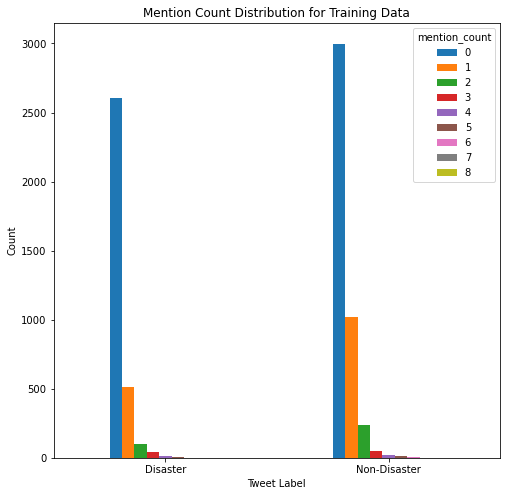

In [56]:
create_bar_plot('mention_count', 'Mention Count Distribution for Training Data')

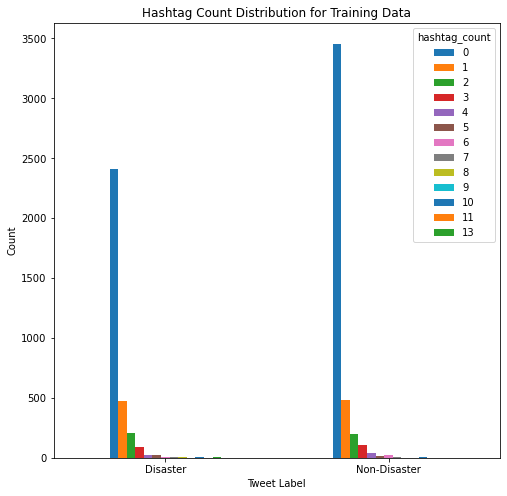

In [57]:
create_bar_plot('hashtag_count', 'Hashtag Count Distribution for Training Data')

From these plots above, we can see that there are differences in the distributions for our three count features, with a marked difference again in the link count that mirrors the difference in the binary feature for links that we saw in our earlier data analysis. With this EDA, it does appear that these metadata features, especially the link features, could add value to our models.

# Data Cleanup

### Setting Up Data for Modeling

To ensure that we are ready for modeling, we are going to split our train data into data and labels, set up a cross-validation procedure, and load in our test data. We want to set up cross-validation (CV) for our model, since we don't have all that much training data and also want to avoid overfitting. To do this, we will set up a CV function here that we can use both for GridSearchCV hyperparameter tuning and model evaluation.

In [58]:
# Dropping all duplicate tweets based off of results of EDA
train_data = train_data.drop_duplicates(subset=['text'], keep='first')

# Creating numpy arrays for labels and tweets for modeling
train_labels = np.array(train_data['target'])
train_text = np.array(train_data['text'])

# Dropping the label column from the train data
train_data.drop(columns=["target"])

# Loading in the test data and creating numpy arrays for the text
# Test data doesn't have labels so will not create array for that
test_data =  pd.read_csv('data/nlp-getting-started/test.csv')
test_text = np.array(test_data.text)

# See more information about parameters here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# "n_splits" splits our data into 10 training/validation sets
# "shuffle" shuffles the data before splitting into batches, "random_state" allows for reproducability across function calls
cv = KFold(n_splits=10, random_state=1, shuffle=True)

## Text Preprocessing

In text classification problems, text pre-processing is a crucial part to prepping our data for analysis. This can be found in our text_clean function. Some pre-processing considerations we have made include:
* removing numbers, symbols, and punctuation
* standardizing to lowercase text
* remove stop words
* word stemming
* trailing spaces
* Lemmatize: (study -> study, studies -> study)
* Stemmatize: (study -> study, studies -> studi)

In [59]:
# Preprocess the data prior to running the model using this function
# TODO: Here I've commented out the punctuation regex section
# Feel free to uncomment that part BUT I think we should leave it out
# altogether. See below for usage.

def preprocess(text, method=None, tokenizer=sent_tokenize, rm_stop=False): 
    """Returns a text processed string.

    Arguments:
    text      -- String, func is designed for loops
    
    method    -- ('s','l') Specify from s - stemmatize, l - lemmatize.
                 None will mean you do not want to remove suffix.
                 
    tokenizer -- Any tokenizer function, from word to sentence to tweet.
                 Tokenizer must not be an object.method unless you
                 specifiy it to be like TweetTokenizer.tokenize.
                 Sentence tokenizer is initialized here.
                 
    rm_stop   -- Bool. Remove stop words or not.
    """

    #remove line breaks
    text = re.sub(r"\n","",text)
    #remove trailing spaces
    text = re.sub(r'[ \t]+$','', text)
    #convert to lowercase 
    text = text.lower()
    #remove digits and currencies 
    text = re.sub(r"\d+","",text) 
    text = re.sub(r'[\$\d+\d+\$]', "", text)
    #remove dates 
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    #remove non-ascii
    text = re.sub(r'[^\x00-\x7f]',r' ',text) 
    # Replacing all links with standard link
    #text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) 
    #text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    text = re.sub(link_regex, "http://t.co", text)
    # separate out mention symbol from text so that models can learn from number of mentions
    p = re.compile(mention_regex)
    text = p.sub(r'@ \1',text)

    # separate out hashtag symbol from hashtag so that models can learn from number of hashtags
    q = re.compile(hashtag_regex)
    text = q.sub(r'# \1',text)
    
    # remove retweet indicator text as it's rarely used
    text = re.sub(retweet_indicator, "", text)
    
    #remove punctuation
    # Leave it? or talking point?!
    #text = re.sub(r'[^\w\s]','',text)
    
    if rm_stop:
        filtered_tokens = [word for word in tokenizer(text) 
                           if not word in set(stopwords.words('english'))]
        text = " ".join(filtered_tokens)
        
    if method == 'l':
        lemmer = WordNetLemmatizer()
        lemm_tokens = [lemmer.lemmatize(word) 
                       for word in tokenizer(text)]
        return " ".join(lemm_tokens)
    
    elif method == 's':
        porter = PorterStemmer()
        stem_tokens = [porter.stem(word) 
                       for word in tokenizer(text)]
        return " ".join(stem_tokens)
    return text

# Usage
### If someone wants to write a function that spits out all the possible model methods please do. This is to keep in mind that we are using K-folds CV to bag-> bootstrap our data.

In [60]:
def run_model_on_preprocessed_text(preprocessed_text):
    tfidf = TfidfVectorizer()
    transformed_data = tfidf.fit_transform(preprocessed_text)
    model = MultinomialNB(alpha=0.9) # Best alpha from project 3
    accuracy_scores = cross_val_score(model, transformed_data, train_labels, scoring='accuracy', cv=cv, n_jobs=-1)
    f1_scores = cross_val_score(model, transformed_data, train_labels, scoring='f1', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(accuracy_scores), std(accuracy_scores)))
    print('F1 Scores: %.3f (%.3f)' % (mean(f1_scores), std(f1_scores)))

def preprocess_text():
    return [preprocess(i) for i in train_data.text]
    
def preprocess_text_with_additional_cleaning(tokenizer):
    return [preprocess(i,method='l',tokenizer=tokenizer,rm_stop=True) for i in train_data.text]

np.random.seed(0)
print('Score on no SW removal, no suffix striping and TFIDF:')
run_model_on_preprocessed_text(preprocess_text())
print('Test on Lemmatize, remove stop and CountVectorize:')
run_model_on_preprocessed_text(preprocess_text_with_additional_cleaning(word_tokenize))

Score on no SW removal, no suffix striping and TFIDF:
Accuracy: 0.802 (0.012)
F1 Scores: 0.737 (0.018)
Test on Lemmatize, remove stop and CountVectorize:
Accuracy: 0.805 (0.014)
F1 Scores: 0.748 (0.020)


### Commented out the usage below because I (Aastha) changed the final proect to work with only one train set (because CV) and standardizing variables

In [61]:
# np.random.seed(0)
# #df_ = df.sample(frac=1).reset_index()

# # No stop word removal and no suffix cleaning. Naive Bayes example run
# # I'll use CountVectorize in this to vectorize data.

# df_ = df

# # Process data in loop
# processed_full = []
# for i in df_.text:
#     processed_full.append(preprocess(i))
# df_.text = processed_full

# # numtest = int(len(df_)/3.5)
# # df_test = df_[:int(numtest/2)].reset_index(drop=True)
# # df_dev = df_[int(numtest/2):numtest].reset_index(drop=True)
# numtest = int(len(df_)/5)
# df_train = df_[numtest:].reset_index(drop=True)
# df_test = df_[:numtest].reset_index(drop=True) 

# train_data, train_label = np.array(df_train.text), np.array(df_train.target)
# dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
# test_data, test_label = np.array(df_test.text), np.array(df_test.target)
# # Naive Bayes example run
# # I'll use TF-IDF in this to vectorize data.

# tfidf = TfidfVectorizer()
# t_data = tfidf.fit_transform(train_data)
# dt_data = tfidf.transform(dev_data)
# tt_data = tfidf.transform(test_data)
# m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label)
# pred = m_nb.predict(dt_data)
# pred_test = m_nb.predict(tt_data)
# print('Score on no SW removal, no suffix striping and TFIDF:')
# print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
# print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))
# print()


# # Lemmatization, no stop words removal, Naive Bayes example run
# # I'll use CountVectorize in this to vectorize data.

# tokenizer = word_tokenize
# df_ = df

# processed_full = []
# for i in df_.text:
#     processed_full.append(preprocess(i,method='l',tokenizer=tokenizer,rm_stop=True))
# df_.text = processed_full

# numtest = int(len(df_)/5)
# df_train = df_[numtest:].reset_index(drop=True)
# df_test = df_[:numtest].reset_index(drop=True)

# train_data, train_label = np.array(df_train.text), np.array(df_train.target)
# dev_data, dev_label = np.array(df_dev.text), np.array(df_dev.target)
# test_data, test_label = np.array(df_test.text), np.array(df_test.target)

# tfidf = CountVectorizer(ngram_range=(1,1))
# t_data = tfidf.fit_transform(train_data)
# dt_data = tfidf.transform(dev_data)
# tt_data = tfidf.transform(test_data)
# m_nb = MultinomialNB(alpha=0.9).fit(t_data, train_label) # best alpha from project 3
# pred = m_nb.predict(dt_data)
# pred_test = m_nb.predict(tt_data)
# print()
# print('Test on Lemmatize, remove stop and CountVectorize:')
# print('F1 Score: {:.4f}'.format(metrics.f1_score(test_label, pred_test, average='weighted')))
# print('Accuracy: {:.4f}'.format(metrics.accuracy_score(test_label, pred_test)))

#### Clean the data and strip

### After the data has been cleaned and text pre-processed, we can begin exploring different algorithms. The three machine learning algorithms we will focus on are:
* Naive Bayes
* Logistic Regression
* SVM
* KMeans clustering

## Logistic Regression Model Optimization



In [62]:
#CREDIT TO SOURCES: 
#https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
#https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/
#https://towardsdatascience.com/natural-language-processing-on-multiple-columns-in-python-554043e05308

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

#drop duplicates
train_data = train_data.drop_duplicates(subset=['text'], keep='first')
train_labels = train_data.target

#vectorize data
vectorizer = CountVectorizer(preprocessor=text_clean, stop_words='english')
vtrain = vectorizer.fit_transform(train_data.text)
text_train = pd.DataFrame(vtrain.todense(), columns = vectorizer.get_feature_names_out())

#generate TfidfVectorizer data
tfid_vectorizer = TfidfVectorizer()
t_train = tfid_vectorizer.fit_transform(train_data.text)
tfid_text_train = pd.DataFrame(t_train.todense(), columns = tfid_vectorizer.get_feature_names_out())

#determine additional features to include in model 
features = ['is_retweet', 'has_mentions', 'has_links']
features_train = train_data[features]

#use hstack to combine CountVectorizer and addl feature data 
train = np.hstack((features_train, text_train))

#use hstack to combine TfidfVectorizer and addl feature data 
tfid_train = np.hstack((features_train, tfid_text_train))

def log_model(train, labels):
  #define c values for testing
  c_values = [0.001,0.01,0.1, 0.5, 1,10,100]
  accuracy_score_list = []
  f1_score_list = []

  #build model
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  for c in c_values: 
    model = LogisticRegression(C=c, solver="liblinear", multi_class="auto")
    accuracy_score = cross_val_score(model, train, labels, cv=10, scoring='accuracy')
    accuracy_score_list.append(accuracy_score.mean())
    f1_score = cross_val_score(model, train, labels, cv=10, scoring='f1')
    f1_score_list.append(f1_score.mean())

  #convert lists to arrays
  accuracy_scores = np.array(accuracy_score_list)
  f1_scores = np.array(accuracy_score_list)

  #identify max scores
  max_accuracy_score = np.where(accuracy_score_list == max(accuracy_score_list))
  max_f1_score = np.where(f1_score_list == max(f1_score_list))

  #print max scores
  string = "F1 score of {:.2%}".format(f1_scores[max_f1_score[0][0]]), "with a C =" , c_values[max_f1_score[0][0]], "and the highest accuracy score of {:.2%}".format(accuracy_scores[max_accuracy_score[0][0]]), "with C =", c_values[max_accuracy_score[0][0]], "."
  return string

print("The model using CountVectorizer had the highest", *log_model(train, train_labels))
print("The model using TfidfVectorizer had the highest", *log_model(tfid_train, train_labels))

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

## SVM Model Optimization

In [66]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

def run_svm_on_transformed_data(transformed_data):
    accuracy_gridsearch_model = fit_gridsearch_model(transformed_data, 'accuracy')
    f1_gridsearch_model = fit_gridsearch_model(transformed_data, 'f1')

    print('Best params for accuracy: ', accuracy_gridsearch_model.best_params_)
    print('Mean score for accuracy: ', accuracy_gridsearch_model.cv_results_['mean_test_score'])

    print('Best params for f1: ', f1_gridsearch_model.best_params_)
    print('Mean score for f1: ', f1_gridsearch_model.cv_results_['mean_test_score'])
    
def fit_gridsearch_model(data, scoring):
    svm_model = svm.SVC(random_state=1) # random_state allows for reproducable outputs across function calls
    gridsearch_model = GridSearchCV(svm_model, param_grid=params, cv=cv, scoring=scoring)
    return gridsearch_model.fit(data, train_labels)

def transform_data_with_count_vectorizer(preprocessed_text):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(preprocessed_text)
    
def transform_data_with_tfidf(preprocessed_text):
    tfidf = TfidfVectorizer()
    return tfidf.fit_transform(preprocessed_text)

np.random.seed(0)

### TODO: Try running/refining these params once your wifi is better
params = {
    'C': [.00001, .001, .01, .1, .5, 1, 2, 5, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'degree': [1, 2, 3, 4, 5, 6],
    'gamma': ['scale', 'auto']
}

print('No SW removal, no suffix striping, TFIDF:')
run_svm_on_transformed_data(transform_data_with_tfidf(preprocess_text()))
print('\n')

print('No SW removal, no suffix striping, CountVectorize:')
run_svm_on_transformed_data(transform_data_with_count_vectorizer(preprocess_text()))
print('\n')

print('Lemmatize, remove stop words, TFIDF:')
run_svm_on_transformed_data(transform_data_with_tfidf(preprocess_text_with_additional_cleaning(word_tokenize)))
print('\n')

print('Lemmatize, remove stop words, CountVectorize:')
run_svm_on_transformed_data(transform_data_with_count_vectorizer(preprocess_text_with_additional_cleaning(word_tokenize)))
print('\n')

No SW removal, no suffix striping, TFIDF:
Best params for accuracy:  {'C': 1e-05}
Best score for accuracy:  0.57376919662672
Best params for f1:  {'C': 1e-05}
Best score for f1:  0.0


No SW removal, no suffix striping, CountVectorize:


KeyboardInterrupt: 